[*********************100%***********************]  1 of 1 completed


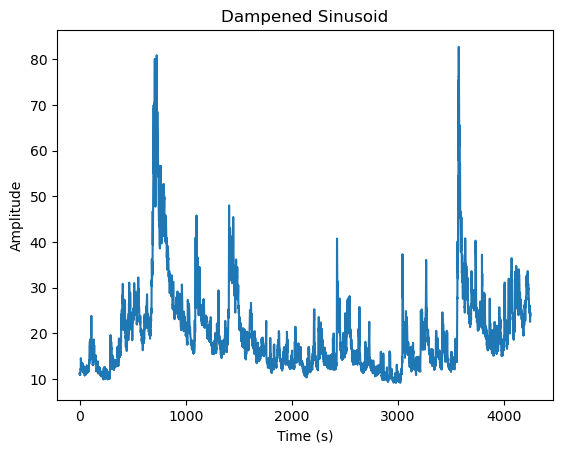

In [16]:
import numpy as np
#Import the Generator from utils- Reload the module to get the latest version
from importlib import reload
import utils
reload(utils)
from utils import series_generator
from utils import stock_price_generator
import matplotlib.pyplot as plt




#Simulate and plot a dampened sinusoid in time



#Genrate the series or download stock data

#y, y_train, y_test, t = series_generator(2500)
y, y_train, y_test, t = stock_price_generator('^VIX')
T, T_train, T_test = len(y), len(y_train), len(y_test)



# Plot the function
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Dampened Sinusoid')
plt.show()



In [17]:
import Models
reload(Models)
from Models import Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

#Preprocess the data to normalize them using the training statistics

y_train_zscore = (y_train - np.mean(y_train)) / np.std(y_train)
y_zscore = (y - np.mean(y_train)) / np.std(y_train)


#Define the model, loss function, and optimizer and train it for 100 epochs.

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), weight_decay=1e-5)
net.train()

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0, T_train - 200, 50):
        # get the inputs; data is a list of [inputs, labels]
        inputs=y_train_zscore[i:i+200]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(y_train_zscore[i+200:i+250])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.10f' %
            (epoch + 1, running_loss))
    running_loss = 0.0

print('Finished Training')

[1] loss: 61.1350747757
[2] loss: 45.7581660785
[3] loss: 46.3717954475
[4] loss: 35.7023897786
[5] loss: 30.1524667740
[6] loss: 27.6147203464
[7] loss: 41.4566996694
[8] loss: 28.0812341869
[9] loss: 18.3609913979
[10] loss: 29.5748536624
[11] loss: 17.7309231590
[12] loss: 14.8262822498
[13] loss: 13.3616905939
[14] loss: 11.9863338545
[15] loss: 11.7738507139
[16] loss: 10.9595438689
[17] loss: 16.1627520546
[18] loss: 11.6931150053
[19] loss: 8.8351040594
[20] loss: 9.6939949580
[21] loss: 16.4074805081
[22] loss: 13.1859872770
[23] loss: 20.1729276851
[24] loss: 12.2654995080
[25] loss: 15.1908649914
[26] loss: 8.5601545693
[27] loss: 7.1890269984
[28] loss: 7.6009898838
[29] loss: 12.4907133393
[30] loss: 11.4970412049
[31] loss: 22.4658663254
[32] loss: 7.5620675804
[33] loss: 13.0745620187
[34] loss: 10.4758816725
[35] loss: 19.8801926244
[36] loss: 7.6188521506
[37] loss: 10.6719798185
[38] loss: 8.6880603163
[39] loss: 16.3247698694
[40] loss: 7.6578526176
[41] loss: 12.0614

In [18]:
#Test the model on the entire data set and plot the results.
net.eval()
y_pred = []
for i in range(0, T - 200, 50):
    inputs=y_zscore[i:i+200]
    inputs = torch.tensor(inputs)
    outputs = net(inputs.float())
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(T-200)
#Denormalize the prediction
y_pred = y_pred*np.std(y_train) + np.mean(y_train)


#plot with plotly with a line where the training set ends
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:T], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[T_train], t[T_train]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.
error = 0
for i in range(T_train, T):
    error = error + (y[i] - y_pred[i-200])**2
error = error/T_test
print(error)


87.21492567004832


Optimal parameters:  alpha_mu = 1.0,  alpha_sigma = 0.007015341795279053, mu_0 = 12.258406802821584, sigma2_0 = 1.0, nu = 50.0


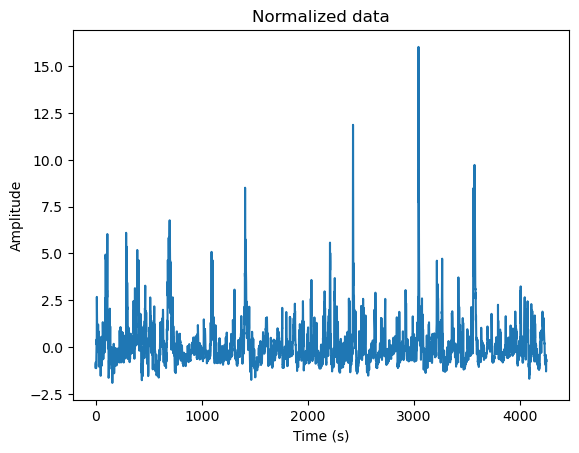

The share of points that are outside the 95% variability interval is 5.294117647058823%
The share of y t+1 that are outside the 95% variability interval is 5.811764705882353%


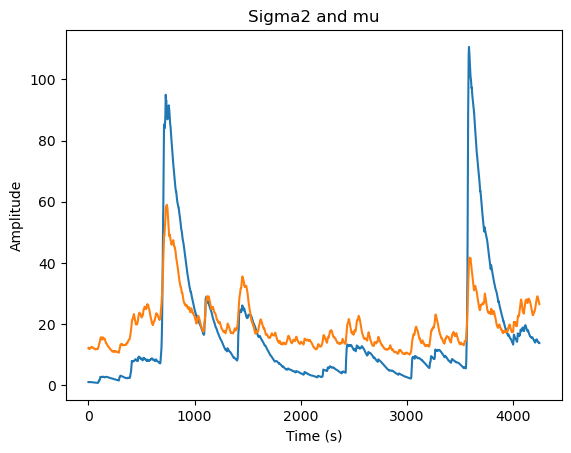

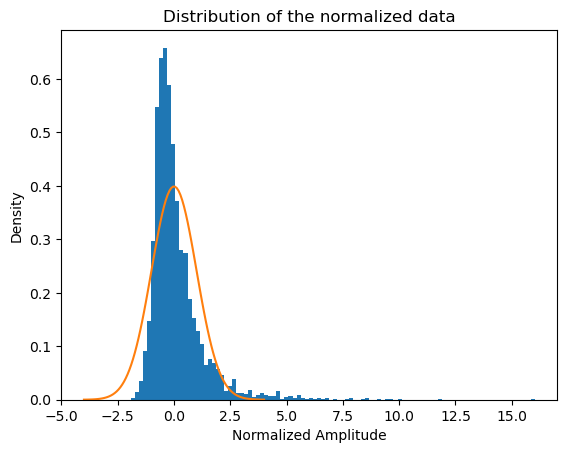

In [19]:
import GAS_norm
reload(GAS_norm)
from GAS_norm import SD_Normalization_Gaussian 
from GAS_norm import SD_Normalization_Student
import numpy as np


#mu_list, sigma2_list, y_norm = SD_Normalization_Gaussian(y, y_train, 'Full', mode='predict', norm_strength=[1,1])
mu_list, sigma2_list, y_norm = SD_Normalization_Student(y, y_train,  mode='predict', norm_strength=[0.05 ,0.5])



#Plot the normalized data

plt.plot(t[0:T], y_norm)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Normalized data')
plt.show()

#Plot the original data with the predicted mean and 95% variability interval

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[0:T], y=mu_list, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=t[0:T], y=mu_list+1.96*np.sqrt(sigma2_list), mode='lines', name='Upper Bound'))
fig.add_trace(go.Scatter(x=t[0:T], y=mu_list-1.96*np.sqrt(sigma2_list), mode='lines', name='Lower Bound'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()


#Write the share of points that are outside the 95% variability interval

share = np.sum((y > mu_list+1.96*np.sqrt(sigma2_list)) | (y < mu_list-1.96*np.sqrt(sigma2_list)))/len(y)
print("The share of points that are outside the 95% variability interval is {}%".format(share*100))

#Write the share of y_{t+1} that are outside the 95% variability interval

share = np.sum((y[1:] > mu_list[0:-1]+1.96*np.sqrt(sigma2_list[0:-1])) | (y[1:] < mu_list[0:-1]-1.96*np.sqrt(sigma2_list[0:-1])))/len(y)
print("The share of y t+1 that are outside the 95% variability interval is {}%".format(share*100))

#Plot sigma_list and mu_list in the same plot
plt.plot(t[0:T], sigma2_list)
plt.plot(t[0:T], mu_list)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sigma2 and mu')
plt.show()

#Plot the distributino of the normalized and unormalized data and compare it with a standard normal distribution

import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y_norm, bins=100, density=True)
plt.plot(np.linspace(-4, 4, 100), stats.norm.pdf(np.linspace(-4, 4, 100), 0, 1))
plt.xlabel('Normalized Amplitude')
plt.ylabel('Density')
plt.title('Distribution of the normalized data')
plt.show()



In [34]:
#Redo the training with the new strategy
import Models
reload(Models)
from Models import GAS_Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


#Divide the data into training and testing sets. The first 1500 time steps of y will be used for training and the last 1000 for testing.

y_norm_train = y_norm[0:T_train]
y_norm_test = y_norm[T_train:T]

#Define the model, loss function, and optimizer and train it for 100 epochs.
#The training is divided in more phases to avoid gradients size problems.
#We first train only the mu layer to make linear predictions with mean information. All the rest is set to zero. 
#Then we fix the mu layer and train the nonlinear part. 
#Fianllly we train the sigma layer.


gas_net = GAS_Net()
gas_net.float()
gas_net.train()
criterion = nn.MSELoss()
model_parameters = gas_net.named_parameters()
optimizer_mu = optim.Adam([param for name, param in model_parameters if 'mu_layer' in name], weight_decay=1e-5)
model_parameters = gas_net.named_parameters()
optimizer_eps = optim.Adam([param for name, param in model_parameters if 'fc1' in name or 'fc2' in name or 'fc3' in name or 'relu' in name], weight_decay=1e-5)
model_parameters = gas_net.named_parameters()
optimizer_sigma = optim.Adam([param for name, param in model_parameters if 'sigma_layer' in name], weight_decay=1e-5)
optimizer_list = [optimizer_mu, optimizer_eps, optimizer_sigma]

for phase in range(2):
    optimizer = optimizer_list[phase]
    for epoch in range(100):  # loop over the dataset multiple times
        running_loss = 0.0
        for i in range(0, T_train - 200, 50):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs=y_norm_train[i:i+200]
            inputs = torch.tensor(inputs)
            labels = torch.tensor(y_train[i+200:i+250])
            mu_vector = torch.tensor(mu_list[i:i+200])
            sigma2_vector = torch.tensor(sigma2_list[i:i+200])

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = gas_net(inputs.float(), mu_vector.float(), sigma2_vector.float(), 1)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        print('[%d] loss: %.10f' %
                (epoch + 1, running_loss))
        running_loss = 0.0

print('Finished Training')

[1] loss: 10281.1073489189
[2] loss: 6262.0639839172
[3] loss: 5798.9964962006
[4] loss: 5462.6725206375
[5] loss: 5233.9132897854
[6] loss: 5082.2402820587
[7] loss: 4981.6644594669
[8] loss: 4914.1481177807
[9] loss: 4867.7943853140
[10] loss: 4834.8748943806
[11] loss: 4810.4013478756
[12] loss: 4791.1775553226
[13] loss: 4775.1673156023
[14] loss: 4761.0797973871
[15] loss: 4748.1014378071
[16] loss: 4735.7186381817
[17] loss: 4723.6111804247
[18] loss: 4711.5795619488
[19] loss: 4699.5040944815
[20] loss: 4687.3153331280
[21] loss: 4674.9778574705
[22] loss: 4662.4781059027
[23] loss: 4649.8178733587
[24] loss: 4637.0064511299
[25] loss: 4624.0609036684
[26] loss: 4611.0003908873
[27] loss: 4597.8464951515
[28] loss: 4584.6215040684
[29] loss: 4571.3470491171
[30] loss: 4558.0444896221
[31] loss: 4544.7327560186
[32] loss: 4531.4307305813
[33] loss: 4518.1555774212
[34] loss: 4504.9225418568
[35] loss: 4491.7448509932
[36] loss: 4478.6355662346
[37] loss: 4465.6051990986
[38] loss

In [38]:
#Test the model on the entire data set and plot the results.
gas_net.eval()
y_pred = []
for i in range(0, T - 200, 50):
    inputs=y_norm[i:i+200]
    inputs = torch.tensor(inputs)
    mu_vector = torch.tensor(mu_list[i:i+200])
    sigma2_vector = torch.tensor(sigma2_list[i:i+200])
    outputs = gas_net(inputs.float(), mu_vector.float(), sigma2_vector.float(), 1)
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(T-200)

#plot with plotly with a line where the training set ends

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:T], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[T_train], t[T_train]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.

error = 0
for i in range(T_train, T):
    error = error + (y[i] - y_pred[i-200])**2
error = error/T_test
print(error)

123.99756066893691


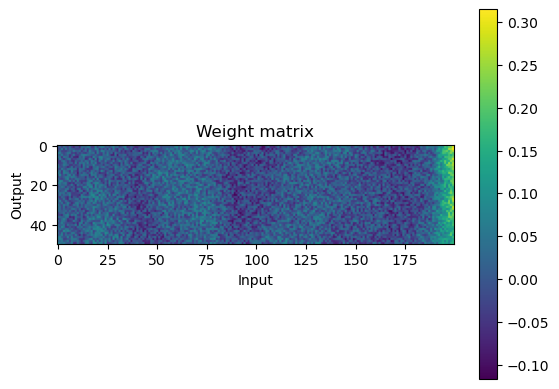

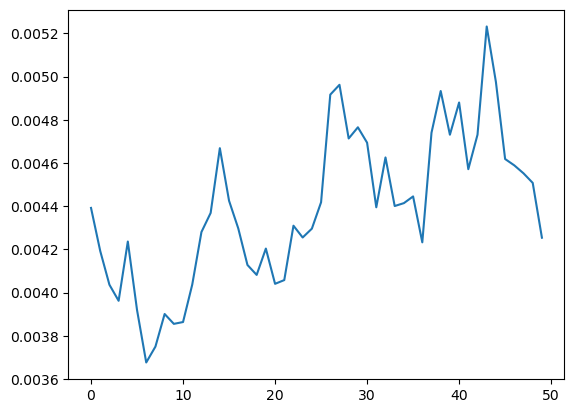

In [22]:
#Plot the weight matrix of the last layer of the network as an heatmap and add the legend of the colorbar

weights = gas_net.mu_layer.weight.detach().numpy()
plt.imshow(weights)
plt.colorbar()
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Weight matrix')

plt.show()

#Now plot the mean of the weights with respect to each input

weights = gas_net.mu_layer.weight.detach().numpy()
plt.plot(weights.mean(axis=1))






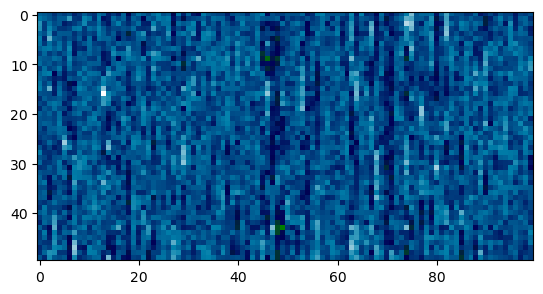

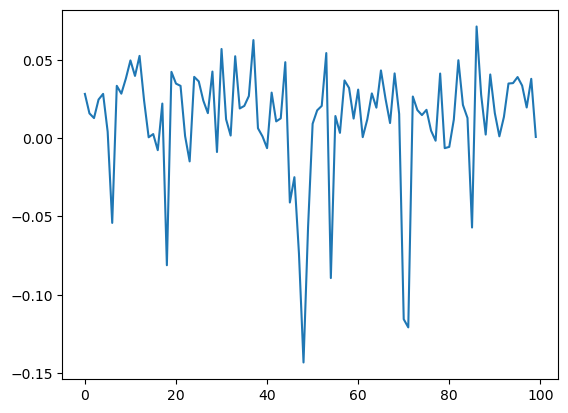

In [23]:
#Plot the weight matrix of the last layer of the network as an heatmap

weights = gas_net.fc3.weight.detach().numpy()
plt.imshow(weights, interpolation='nearest', cmap=plt.cm.ocean)

plt.show()

#Now plot the mean of the weights with respect to each input

weights = gas_net.fc3.weight.detach().numpy()
plt.plot(weights.mean(axis=0))


In [24]:
#Define a neural network class that use Revin as normalization procedure
#Revin expect the input and output to be (batch, time, features) so we need to reshape the data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


In [25]:
import Models
reload(Models)
from Models import Revin_Net


#Define the model, loss function, and optimizer and train it for 100 epochs.

net = Revin_Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), weight_decay=1e-5)
net.train()

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0, T_train - 200, 50):
        # get the inputs; data is a list of [inputs, labels]
        inputs=y_train[i:i+200]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(y_train[i+200:i+250])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.10f' %
            (epoch + 1, running_loss))
    running_loss = 0.0

print('Finished Training')

[1] loss: 4040.1744767427
[2] loss: 3246.3591818810
[3] loss: 2499.0695964098
[4] loss: 2127.3261324167
[5] loss: 1554.1167686582
[6] loss: 1189.7355604172
[7] loss: 1046.3556228876
[8] loss: 877.9269613624
[9] loss: 977.8094500899
[10] loss: 768.4851765037
[11] loss: 689.8026826978
[12] loss: 720.0905445814
[13] loss: 648.6964212060
[14] loss: 526.3635900617
[15] loss: 446.7841661572
[16] loss: 406.5107840300
[17] loss: 505.3373831511
[18] loss: 620.9943265915
[19] loss: 695.8915911317
[20] loss: 574.9922707081
[21] loss: 465.9037562609
[22] loss: 630.9919100404
[23] loss: 469.7536094189
[24] loss: 399.6499840021
[25] loss: 365.3650877476
[26] loss: 338.0976522565
[27] loss: 406.7602089643
[28] loss: 412.8884695172
[29] loss: 571.7759003639
[30] loss: 576.1498278975
[31] loss: 709.4676297307
[32] loss: 410.7214379311
[33] loss: 358.3517719507
[34] loss: 327.4920191467
[35] loss: 321.4940545261
[36] loss: 254.9571721554
[37] loss: 287.0687989295
[38] loss: 242.3497520983
[39] loss: 247

In [26]:
#Test the model on the entire data set and plot the results.
net.eval()
y_pred = []
for i in range(0, T - 200, 50):
    inputs=y[i:i+200]
    inputs = torch.tensor(inputs)
    outputs = net(inputs.float())
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(T - 200)

#plot with plotly with a line where the training set ends
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:T], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[T_train], t[T_train]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.
error = 0
for i in range(T_train, T):
    error = error + (y[i] - y_pred[i-200])**2
error = error/T_test
print(error)

104.00854292399346
